# IMPORTS

In [1]:
# Do Imports
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai
from fastai import train as tr

import pickle
import matplotlib as mpl

In [2]:
os.chdir('../HEPAutoencoders')
from nn_utils import AE_big, AE_3D_200
from utils import plot_activations
import my_matplotlib_style as ms
# mpl.rc_file('../HEPAutoencoders/my_matplotlib_rcparams')

In [210]:
'''CHECKING FOR GPU'''

print(torch.cuda.is_available())
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [4]:
'''USE CPU FOR FAST.AI'''

fastai.torch_core.defaults.device = 'cpu'

# LOADING DATA

In [5]:
'''LOAD DATA'''

train = pd.read_pickle('../data/all_jets_train_4D_100_percent.pkl')
test = pd.read_pickle('../data/all_jets_test_4D_100_percent.pkl')
n_features = len(train.loc[0])

In [6]:
train.head(5)

,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871


In [7]:
test.head(5)

,m,pt,phi,eta
85972,4983.729980,23798.070312,1.962157,-0.059532
38742,5435.273438,21881.867188,1.035412,0.734343
128711,5239.408691,24608.134766,-1.121055,0.828848
28751,14121.240234,203110.953125,0.324205,-2.571108
131358,3344.826660,24897.294922,0.395331,1.440069


In [8]:
'''Normalizing the Data'''

# Calculate the train mean/standard-dev
# Use it to normalize train/test.
train_mean = train.mean()
train_std = train.std()
train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x 
test_y = test_x

In [9]:
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(111778, 4) (111778, 4)
(27945, 4) (27945, 4)


In [10]:
'''Make DataBunch'''

# Generate Datasets.
train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

# Instantiate train/valid dataloaders.
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=512)
        
# Make DataBunch for feeding into `basic_train`.
db = basic_data.DataBunch(train_dl, valid_dl)

In [42]:
'''Define Model'''

# Instantiate the model.
model = AE_3D_200().double()

# Define Loss
loss_func = nn.MSELoss()

In [43]:
'''Define Learner'''

learn = basic_train.Learner(
    data = db,              # Data Bunch
    model = model,          # Previously define model
    loss_func = loss_func,  # Loss Function
    wd = 1e-6,              # Weight Decay
    callback_fns = ActivationStats, 
    bn_wd = False,          # Don't use weight decay fpr batchnorm layers 
    true_wd = True,          # wd will be used for all optimizers
)

# TRAINING

We follow the following cycle while training : 
- Plot learning rate curve.
- Figure out the optimal learning rate.
- Train the Model.
- Repeat until model converges.

NOTE : You may skip this section and directly load the weigths in the next section to reproduce the graphs.

In [44]:
'''Setup Monitoring Lists'''

train_loss_list = []
valid_loss_list = []

In [45]:
'''Define Useful functions'''

def UpdateLosses(recorder):
    for loss in recorder.losses:
        train_loss_list.append(loss.item())

    for loss in recorder.val_losses:
        valid_loss_list.append(loss.item())

def PlotLosses():
    plt.plot(train_loss_list, 'r')
    points = np.arange(len(train_loss_list)/424) * 424
    
    plt.plot(points[:-1], valid_loss_list, 'ko-')
    plt.show()    
    
def FindLearningRate(learn):
    tr.lr_find(learn)
    learn.recorder.plot()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


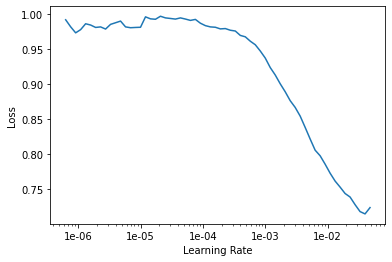

In [46]:
'''Initial Plot'''

FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.983887,1.003772,00:05
1,0.969812,0.986007,00:06
2,0.969930,0.963389,00:05
3,0.926900,0.936134,00:05
4,0.893095,0.904543,00:06
5,0.860185,0.869282,00:06
6,0.825302,0.831588,00:06
7,0.784835,0.792210,00:06
8,0.748922,0.752220,00:06
9,0.706397,0.712761,00:06


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


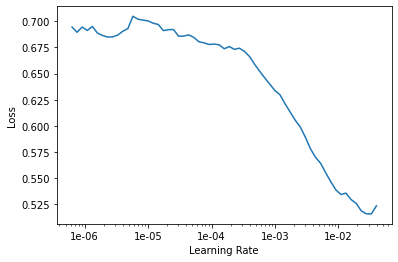

In [47]:
'''Cycle 1'''

lr = 1e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.038914,0.044147,00:05
1,0.031494,0.030730,00:05
2,0.032317,0.030222,00:06
3,0.028122,0.029980,00:06
4,0.028816,0.034977,00:06
5,0.025879,0.024006,00:06
6,0.028045,0.032596,00:06
7,0.032600,0.032200,00:06
8,0.031279,0.036579,00:06
9,0.024573,0.022357,00:06


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


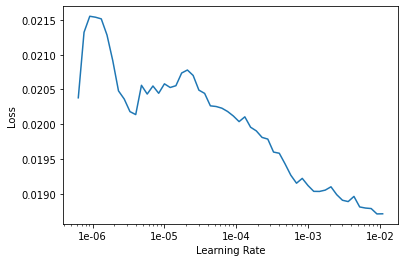

In [48]:
'''Cycle 2'''

lr = 1e-2
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.014121,0.013456,00:05
1,0.012855,0.012845,00:05
2,0.011590,0.011958,00:07


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


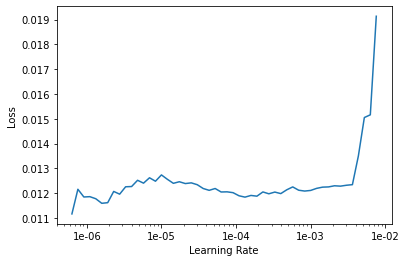

In [49]:
'''Cycle 3'''

lr = 1e-3
learn.fit(3, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.010930,0.011112,00:05
1,0.010153,0.011004,00:06
2,0.010122,0.010824,00:06


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


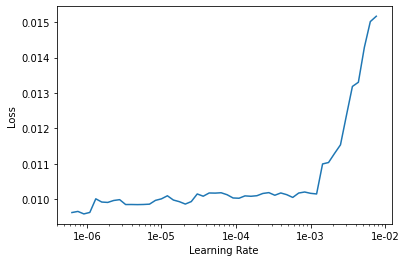

In [54]:
'''Cycle 4'''

lr = 1e-4
learn.fit(3, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.010205,0.010797,00:05
1,0.009839,0.010749,00:05
2,0.009746,0.010732,00:06


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


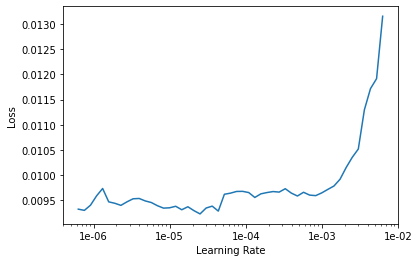

In [58]:
'''Cycle 5'''

lr = 2e-5
learn.fit(3, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009679,0.010715,00:05
1,0.009743,0.010683,00:06
2,0.010009,0.010644,00:06


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


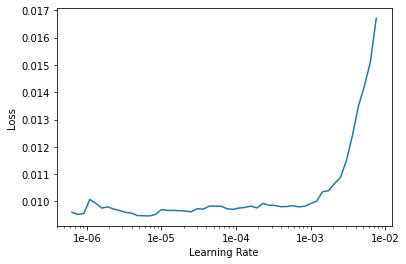

In [60]:
'''Cycle 6'''

lr = 2e-5
learn.fit(3, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009694,0.010634,00:05
1,0.009630,0.010634,00:05
2,0.010319,0.010636,00:06


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


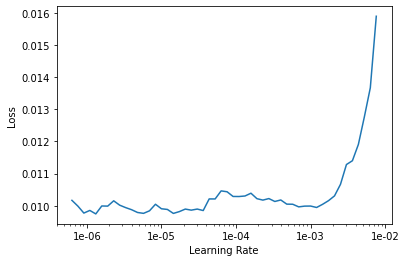

In [61]:
'''Cycle 7'''

lr = 1e-6
learn.fit(3, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009821,0.010637,00:06
1,0.009873,0.010597,00:06
2,0.009748,0.010584,00:07


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


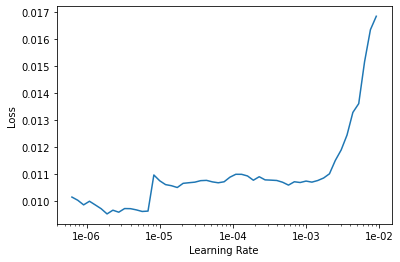

In [62]:
'''Cycle 8'''

lr = 2e-5
learn.fit(3, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009738,0.010569,00:06
1,0.009488,0.010570,00:06
2,0.009602,0.010567,00:07


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


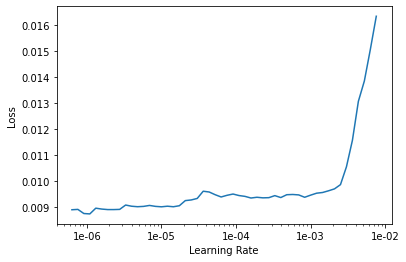

In [63]:
'''Cycle 9'''

lr = 3e-6
learn.fit(3, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009711,0.010566,00:05
1,0.009930,0.010565,00:05
2,0.010047,0.010564,00:06
3,0.009703,0.010564,00:06
4,0.009548,0.010562,00:07
5,0.009958,0.010562,00:06
6,0.009748,0.010561,00:06
7,0.009341,0.010560,00:06
8,0.009372,0.010557,00:06
9,0.009786,0.010556,00:06


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


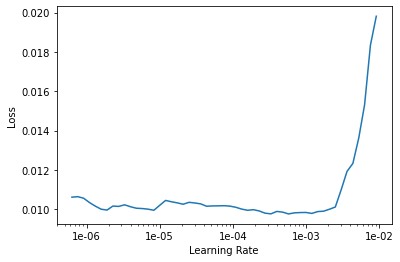

In [64]:
'''Cycle 10'''

lr = 1e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009930,0.010555,00:05
1,0.009701,0.010554,00:05
2,0.010059,0.010552,00:05
3,0.009424,0.010551,00:07
4,0.009743,0.010550,00:06
5,0.009705,0.010548,00:06
6,0.009132,0.010547,00:06
7,0.009621,0.010546,00:06
8,0.009546,0.010544,00:06
9,0.009296,0.010544,00:06


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


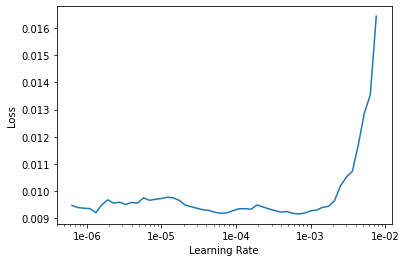

In [66]:
'''Cycle 11'''

lr = 1e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009792,0.010539,00:05
1,0.009505,0.010534,00:05
2,0.009621,0.010529,00:06
3,0.009379,0.010525,00:06
4,0.009749,0.010523,00:07
5,0.009631,0.010519,00:07
6,0.009414,0.010514,00:07
7,0.009700,0.010509,00:07
8,0.009459,0.010507,00:07
9,0.009397,0.010499,00:07


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


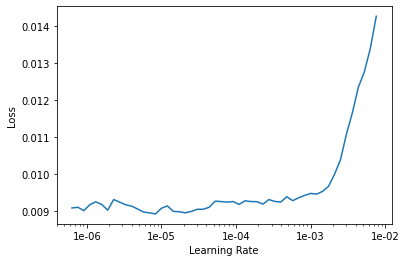

In [68]:
'''Cycle 12'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009367,0.010498,00:08
1,0.009407,0.010494,00:07
2,0.009438,0.010489,00:08
3,0.009515,0.010487,00:10
4,0.009751,0.010482,00:08
5,0.009392,0.010477,00:08
6,0.009731,0.010474,00:08
7,0.009150,0.010470,00:08
8,0.009438,0.010466,00:07
9,0.009405,0.010464,00:07


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


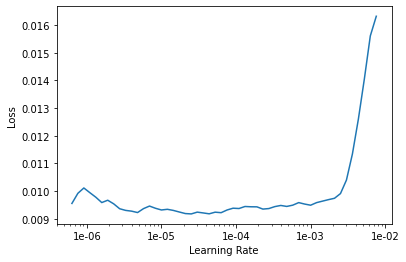

In [70]:
'''Cycle 13'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009243,0.010460,00:07
1,0.009412,0.010456,00:07
2,0.009379,0.010455,00:07
3,0.009519,0.010452,00:07
4,0.009671,0.010447,00:07
5,0.009474,0.010443,00:07
6,0.009516,0.010444,00:07
7,0.009951,0.010437,00:07
8,0.009541,0.010433,00:07
9,0.009553,0.010435,00:07


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


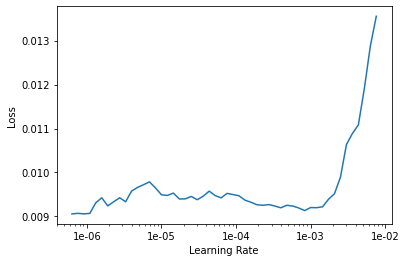

In [72]:
'''Cycle 14'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009367,0.010428,00:07
1,0.009788,0.010426,00:09
2,0.009572,0.010424,00:08
3,0.009666,0.010419,00:08
4,0.009499,0.010417,00:07
5,0.009242,0.010411,00:07
6,0.009492,0.010409,00:07
7,0.009353,0.010406,00:07
8,0.009348,0.010406,00:07
9,0.009613,0.010401,00:07


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


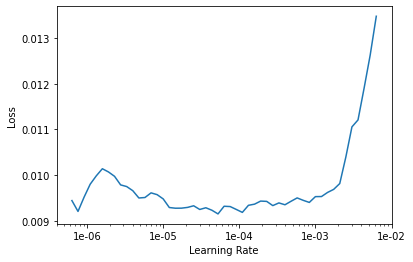

In [74]:
'''Cycle 15'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009573,0.010399,00:07
1,0.009352,0.010395,00:07
2,0.009516,0.010394,00:09
3,0.009357,0.010390,00:08
4,0.009645,0.010389,00:08
5,0.009540,0.010386,00:07
6,0.009546,0.010381,00:09
7,0.009357,0.010381,00:09
8,0.009277,0.010379,00:09
9,0.009650,0.010377,00:08


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


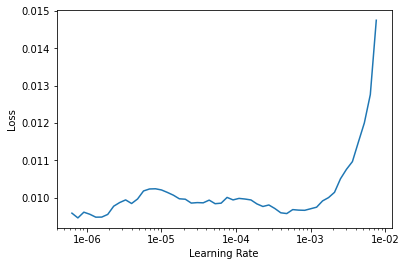

In [76]:
'''Cycle 16'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009331,0.010371,00:08
1,0.009245,0.010369,00:07
2,0.009534,0.010363,00:06
3,0.009384,0.010362,00:07
4,0.009204,0.010359,00:06
5,0.009745,0.010358,00:06
6,0.009531,0.010357,00:06
7,0.009676,0.010351,00:06
8,0.009370,0.010348,00:07
9,0.009601,0.010348,00:07


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


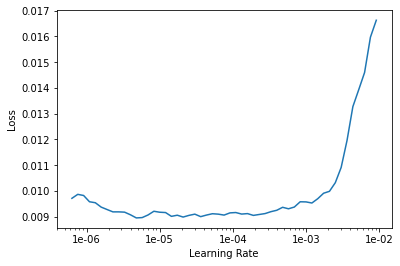

In [78]:
'''Cycle 17'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009389,0.010343,00:05
1,0.009416,0.010341,00:06
2,0.009624,0.010337,00:07
3,0.009411,0.010335,00:08
4,0.009490,0.010334,00:08
5,0.009545,0.010332,00:08
6,0.009251,0.010329,00:08
7,0.009918,0.010323,00:07
8,0.009169,0.010322,00:09
9,0.009469,0.010319,00:09


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


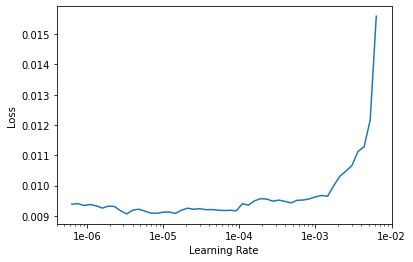

In [81]:
'''Cycle 18'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009523,0.010316,00:06
1,0.009301,0.010318,00:06
2,0.009241,0.010314,00:06
3,0.009257,0.010310,00:06
4,0.009120,0.010307,00:06
5,0.009385,0.010306,00:06
6,0.009033,0.010302,00:06
7,0.009277,0.010299,00:06
8,0.009420,0.010295,00:06
9,0.009066,0.010294,00:08


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


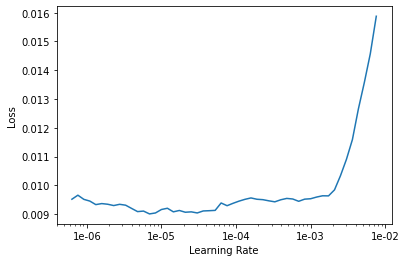

In [83]:
'''Cycle 19'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009272,0.010291,00:05
1,0.009682,0.010291,00:06
2,0.009469,0.010287,00:06
3,0.009145,0.010285,00:06
4,0.009163,0.010282,00:06
5,0.008961,0.010281,00:06
6,0.009238,0.010275,00:07
7,0.009384,0.010274,00:07
8,0.009534,0.010272,00:07
9,0.009419,0.010269,00:06


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


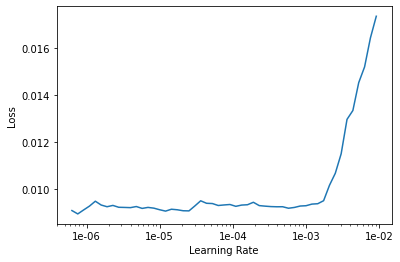

In [119]:
'''Cycle 20'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009301,0.010268,00:05
1,0.009207,0.010263,00:06
2,0.009528,0.010263,00:06
3,0.009264,0.010260,00:06
4,0.009204,0.010255,00:06
5,0.008988,0.010253,00:06
6,0.009219,0.010251,00:06
7,0.009521,0.010249,00:06
8,0.009609,0.010246,00:06
9,0.009581,0.010244,00:06


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


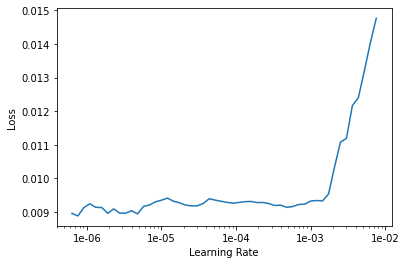

In [125]:
'''Cycle 21'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009825,0.010243,00:06
1,0.009108,0.010238,00:07
2,0.009156,0.010236,00:08
3,0.009091,0.010237,00:08
4,0.009311,0.010231,00:08
5,0.009243,0.010230,00:07
6,0.009274,0.010227,00:07
7,0.009394,0.010226,00:12
8,0.009239,0.010224,00:15
9,0.009161,0.010218,00:09


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


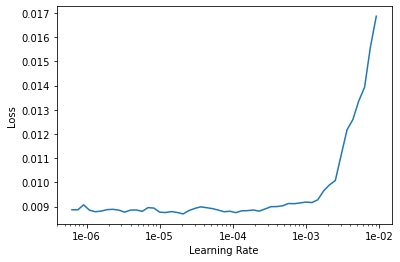

In [127]:
'''Cycle 22'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009334,0.010217,00:06
1,0.008971,0.010215,00:06
2,0.009060,0.010213,00:06
3,0.009047,0.010209,00:06
4,0.009583,0.010208,00:06
5,0.009090,0.010205,00:06
6,0.009307,0.010203,00:06
7,0.009161,0.010201,00:07
8,0.009343,0.010199,00:06
9,0.009051,0.010196,00:06


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


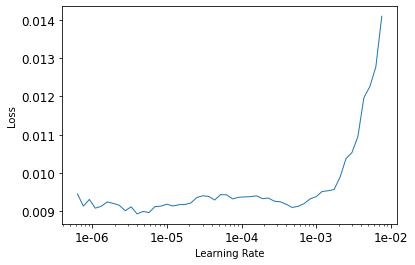

In [140]:
'''Cycle 23'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009249,0.010193,00:05
1,0.009224,0.010191,00:06
2,0.009207,0.010189,00:06
3,0.009227,0.010187,00:06
4,0.009199,0.010186,00:06
5,0.008812,0.010182,00:08
6,0.008966,0.010179,00:08
7,0.009254,0.010178,00:14
8,0.009229,0.010176,00:18
9,0.009315,0.010175,00:16


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


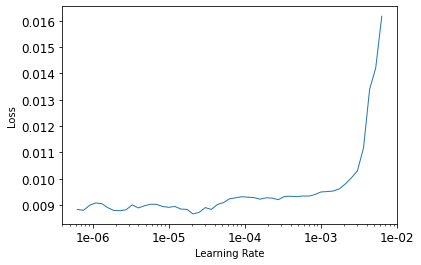

In [142]:
'''Cycle 24'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009332,0.010170,00:05
1,0.009216,0.010169,00:05
2,0.009084,0.010167,00:06
3,0.009339,0.010164,00:06
4,0.009227,0.010161,00:07
5,0.009230,0.010158,00:07
6,0.009356,0.010159,00:07
7,0.009029,0.010154,00:07
8,0.009190,0.010154,00:07
9,0.009673,0.010149,00:08


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


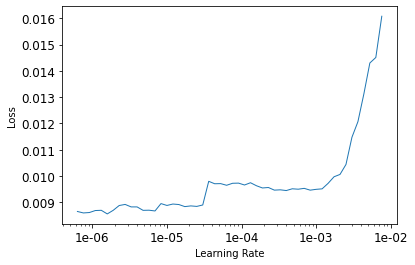

In [144]:
'''Cycle 25'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009371,0.010148,00:07
1,0.009395,0.010146,00:09
2,0.008939,0.010142,00:09
3,0.009272,0.010144,00:09
4,0.009087,0.010138,00:07
5,0.009250,0.010136,00:08
6,0.009005,0.010136,00:07
7,0.009405,0.010132,00:08
8,0.009078,0.010131,00:07
9,0.009030,0.010128,00:07


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


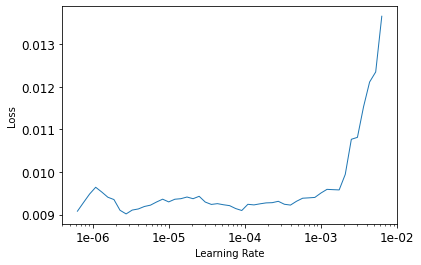

In [146]:
'''Cycle 26'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009262,0.010127,00:05
1,0.009095,0.010122,00:06
2,0.009119,0.010123,00:06
3,0.009194,0.010119,00:06
4,0.009106,0.010118,00:06
5,0.008966,0.010115,00:06
6,0.008962,0.010115,00:06
7,0.009090,0.010111,00:06
8,0.008892,0.010110,00:06
9,0.009294,0.010105,00:07


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


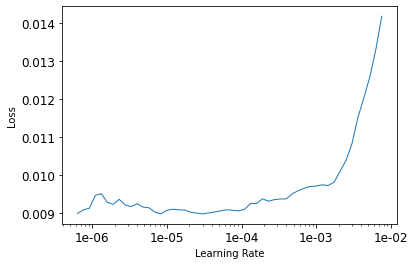

In [148]:
'''Cycle 27'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.008987,0.010105,00:06
1,0.008857,0.010102,00:07
2,0.009052,0.010103,00:06
3,0.009172,0.010099,00:06
4,0.009407,0.010098,00:06
5,0.009216,0.010095,00:06
6,0.009334,0.010092,00:06
7,0.009478,0.010091,00:06
8,0.009480,0.010089,00:06
9,0.008982,0.010085,00:06


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


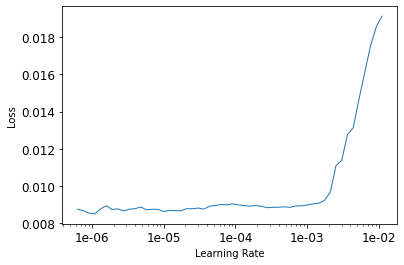

In [151]:
'''Cycle 28'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009098,0.010083,00:05
1,0.009301,0.010081,00:08
2,0.008945,0.010080,00:08
3,0.009392,0.010077,00:08
4,0.009027,0.010076,00:08
5,0.008909,0.010074,00:07
6,0.008811,0.010071,00:07
7,0.008893,0.010069,00:07
8,0.008912,0.010067,00:07
9,0.008768,0.010066,00:08


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


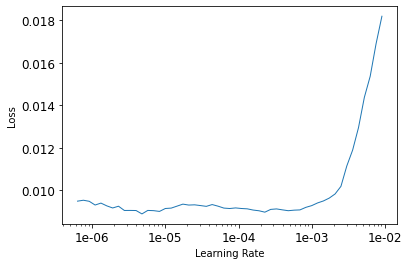

In [153]:
'''Cycle 29'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009149,0.010063,00:05
1,0.008997,0.010061,00:06
2,0.008825,0.010062,00:06
3,0.009419,0.010059,00:06
4,0.009297,0.010057,00:06
5,0.008877,0.010054,00:07
6,0.008946,0.010054,00:07
7,0.009642,0.010051,00:07
8,0.008960,0.010050,00:06
9,0.008901,0.010047,00:07


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


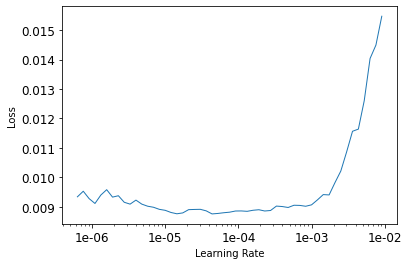

In [155]:
'''Cycle 30'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009570,0.010045,00:06
1,0.009017,0.010041,00:07
2,0.009173,0.010040,00:07
3,0.008999,0.010040,00:07
4,0.009159,0.010038,00:06
5,0.009129,0.010036,00:07
6,0.009039,0.010033,00:07
7,0.008723,0.010032,00:07
8,0.009011,0.010031,00:07
9,0.009098,0.010030,00:07


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


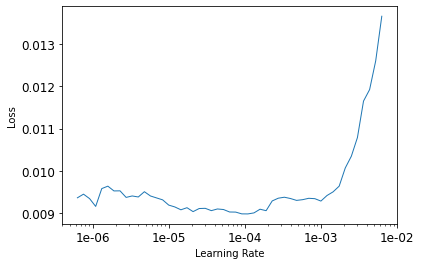

In [157]:
'''Cycle 31'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009253,0.010027,00:05
1,0.008936,0.010025,00:06
2,0.008952,0.010023,00:06
3,0.009282,0.010021,00:06
4,0.008949,0.010019,00:06
5,0.009010,0.010018,00:07
6,0.009339,0.010017,00:06
7,0.009385,0.010012,00:06
8,0.009055,0.010012,00:06
9,0.008953,0.010009,00:06


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


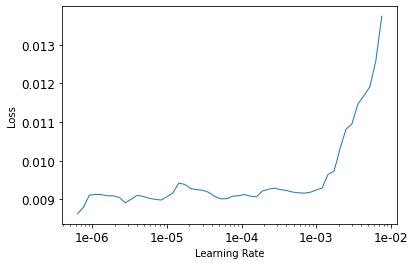

In [159]:
'''Cycle 32'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.009143,0.010007,00:05
1,0.009063,0.010008,00:06
2,0.009179,0.010005,00:06
3,0.008829,0.010004,00:07
4,0.009000,0.010002,00:06
5,0.008881,0.009999,00:06
6,0.008574,0.009996,00:06
7,0.009043,0.009996,00:06
8,0.009057,0.009995,00:07
9,0.008899,0.009992,00:07


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


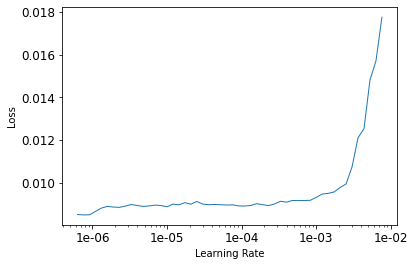

In [161]:
'''Cycle 33'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.008815,0.009991,00:05
1,0.009124,0.009988,00:05
2,0.008928,0.009986,00:06
3,0.008849,0.009987,00:06
4,0.008878,0.009983,00:06
5,0.008896,0.009983,00:06
6,0.009085,0.009981,00:07
7,0.008687,0.009979,00:06
8,0.008984,0.009976,00:06
9,0.008838,0.009975,00:06


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


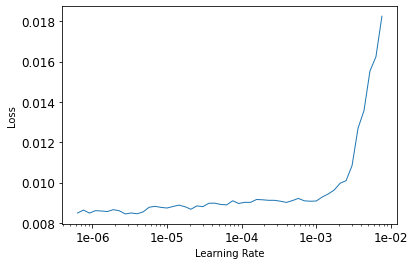

In [163]:
'''Cycle 34'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

epoch,train_loss,valid_loss,time
0,0.008981,0.009970,00:06
1,0.009073,0.009970,00:06
2,0.009132,0.009971,00:07
3,0.009004,0.009967,00:08
4,0.008710,0.009966,00:08
5,0.009006,0.009968,00:07
6,0.008979,0.009963,00:07
7,0.008978,0.009961,00:08
8,0.008620,0.009961,00:07
9,0.008983,0.009958,00:07


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


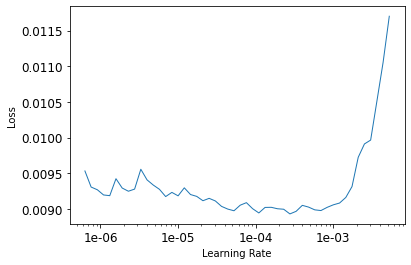

In [166]:
'''Cycle 35'''

lr = 3e-6
learn.fit(10, lr=lr, wd=1e-6)
UpdateLosses(recorder = learn.recorder)
FindLearningRate(learn)

NOTE : We can train still further as the validation loss is still (slowly) decreasing. An ideal learning rate for further training might be in the range [1e-6, 3e-6].

# SAVING AND LOADING

In [167]:
# Save the model to 'models' folder

val_loss = "0.009958"

os.chdir("../model2_AE_3D_100")
learn.save('model2_weights_loss='+val_loss)

# Save the loss lists.
# Useful in plotting and analysing graphs later on.
mdict = {}
list_name = ['train_loss_list', 'valid_loss_list']
for i in range(len(list_name)):
    mdict[list_name[i]] = eval(list_name[i])  

fileObject = open('models/model2_dict_loss='+val_loss+'.pkl','wb')
pickle.dump(mdict,fileObject)   
fileObject.close()

In [168]:
# Load the saved model

val_loss = "0.009958"

os.chdir("../model2_AE_3D_100")
learn.load('model2_weights_loss='+val_loss)

fileObject = open('models/model2_dict_loss='+val_loss+'.pkl','rb')
mdictx = pickle.load(fileObject)  

train_loss_list = mdictx['train_loss_list']
valid_loss_list = mdictx['valid_loss_list']

# EVALUATION : TRAINED AUTOENCODER

In [170]:
'''VALIDATION MSE'''

print("Validation MSE for trained model: ", learn.validate())

Validation MSE for trained model:  [0.009958345899622401]


In [171]:
'''HELPER FUNCTIONS'''

def encode(x):
    '''
    Encode the input vector `x`.
    Returns a Torch.Tensor.
    '''
    x = torch.Tensor(x).double()
    en = model.encode(x).detach()
    return en

def decode(x):
    '''
    Decode the input vector `x`.
    Returns a Torch.Tensor.
    '''
    x = torch.Tensor(x).double()
    en = model.decode(x).detach()
    return en

def predict(x):
    '''
    Predict the reconstructed vector 
    for input vector `x`.
    Returns a Torch.Tensor.
    '''
    x = torch.Tensor(x).double()
    y = model(x).detach()
    return y

def relativeError(x):
    '''
    Returns the relative absolute error between
    the input vector `x` and its reconstruction,
    summed over all dimensions.
    '''
    x = torch.Tensor(x).double()
    y = model(x).detach()
    error = sum(abs((x-y)/x)).item()
    return error

In [172]:
'''EVALUATING RANDOM INPUT'''

input1 = [1,2,3,4]
pred1 = predict(input1)
# print(input1, pred1)
print(relativeError(input1))

1.5174107872193567


In [173]:
'''EVALUATING ACTUAL INPUT'''

input2 = train.values[0]
pred2 = predict(input2)
# print(input2, pred2)
print(relativeError(input2))

0.0563923950689783


# EVALUATION : PRE-TRAINED AUTOENCODER

Note : I have assumed the file stored at `HEPAutoencoders/4D` corresponds to the pre-trained model as it is compatible with the current model and another weight file is not available.

In [24]:
learn1 = learn
os.chdir("../HEPAutoencoders/4D")
learn1.load('tmp')
os.chdir("..")

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f8a26a85410>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f8a26a85990>;

Test: None, model=AE_3D_200(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=MSELoss(), metrics=[], true_wd=True, bn_wd=False, wd=1e-06, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, 

In [25]:
'''VALIDATION MSE'''

print("Validation MSE for pre-trained model: ", learn.validate())

Validation MSE for pre-trained model:  [1.028096650533415]


In [26]:
'''EVALUATING RANDOM INPUT'''

input1 = [1,2,3,4]
pred1 = predict(input1)
# print(input1, pred1)
print(relativeError(input1))

4.021170834626841


In [27]:
'''EVALUATING ACTUAL INPUT'''

input2 = train.values[0]
pred2 = predict(input2)
# print(input2, pred2)
print(relativeError(input2))

4.094252670674253


# GRAPHS

NOTE : All plots correspond to model with `loss=0.009958`.

In [208]:
os.chdir("../model2_AE_3D_100")

In [178]:
'''CALCULATING STATISTICS'''

# Send model to cpu
model.to('cpu')

# Get predictions
data = torch.tensor(test_x.values)
pred = model(data).detach().numpy()

# "Un-normalize" the data
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

# "Un-normalize" the predictions
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)

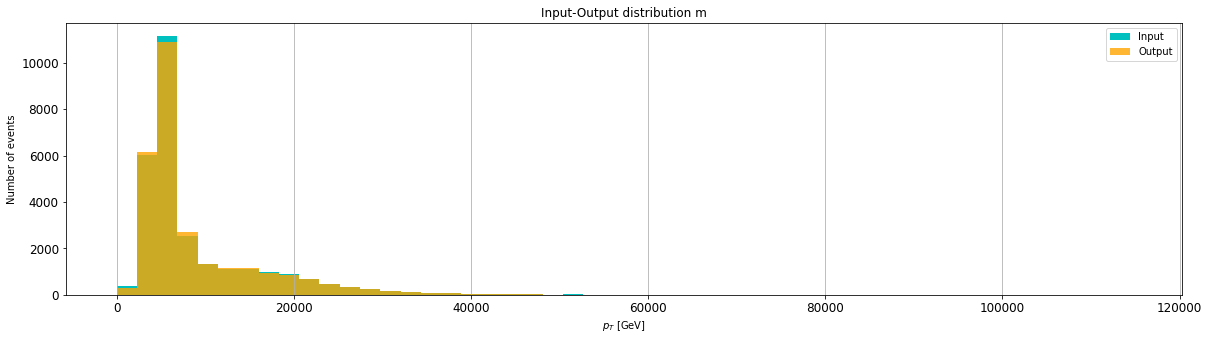

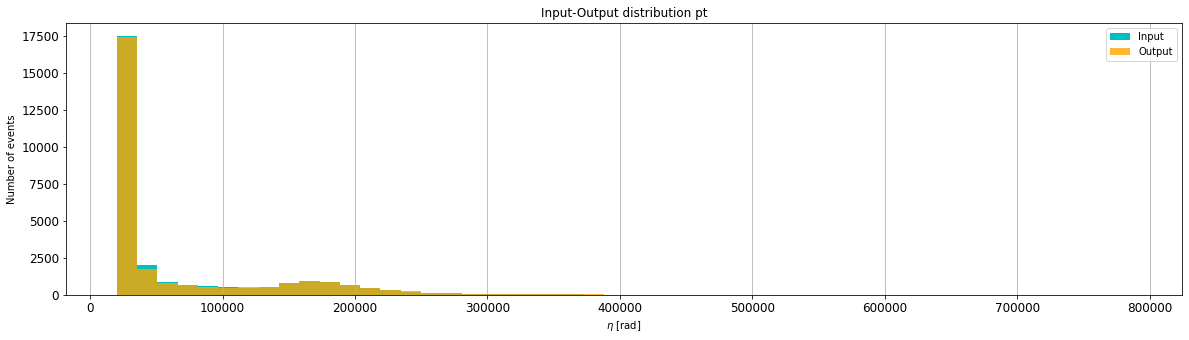

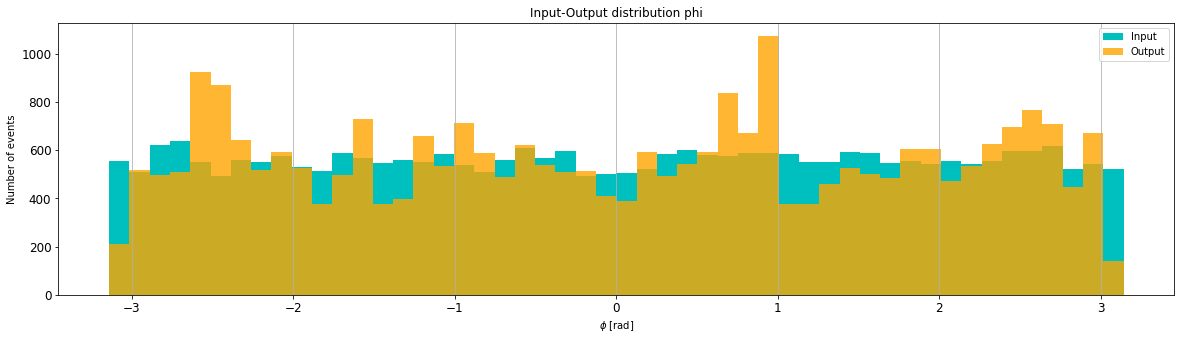

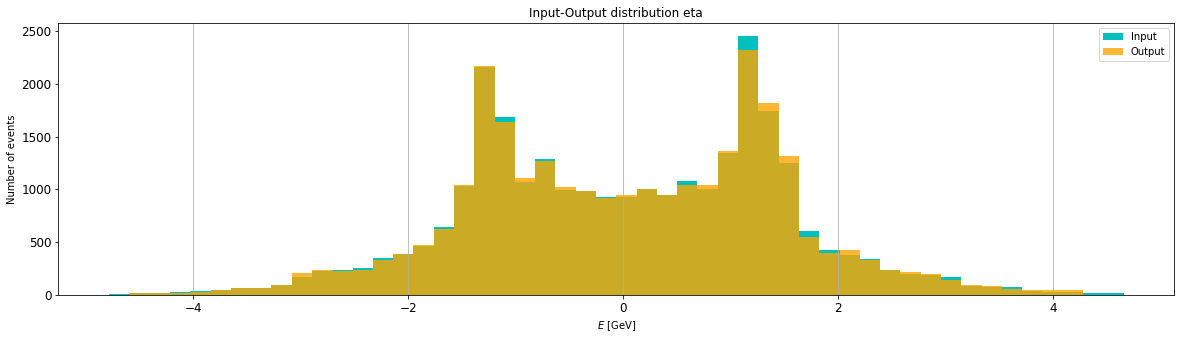

In [179]:
'''PLOTTING DISTRIBUTION HISTOGRAMS'''

# Close previous Plots
plt.close('all')

# Define data variables
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']

# Define data variable units
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']

# Other graph params
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']
alph = 0.8
n_bins = 50

for idx in np.arange(4):
    fig_name = "Input-Output distribution " + train_x.columns[idx]
    plt.figure(figsize=[20,5])
    
    # Plot input histogram
    n_hist_data, bin_edges, _ = plt.hist(data[:,idx], color=colors[1], label='Input', alpha=1, bins=n_bins)
    
    # Plot output histogram
    n_hist_pred, _, _ = plt.hist(pred[:,idx], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    
    # Set misc. graph setings
    plt.title(fig_name)                                    # Set title
    plt.xlabel(variable_list[idx] + ' ' + unit_list[idx])  # Set label for x-axis
    plt.ylabel('Number of events')                         # Set label for y-asix
    plt.grid(axis='x')                                     # Set grid
    plt.legend()                                           # Set legend
    
    # Save figures
    plt.savefig("graphs/Input-Output_distribution_" + train_x.columns[idx] + ".png", dpi=200)
    
    # Show figures
    plt.show()

/home/black/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/black/.local/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/home/black/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


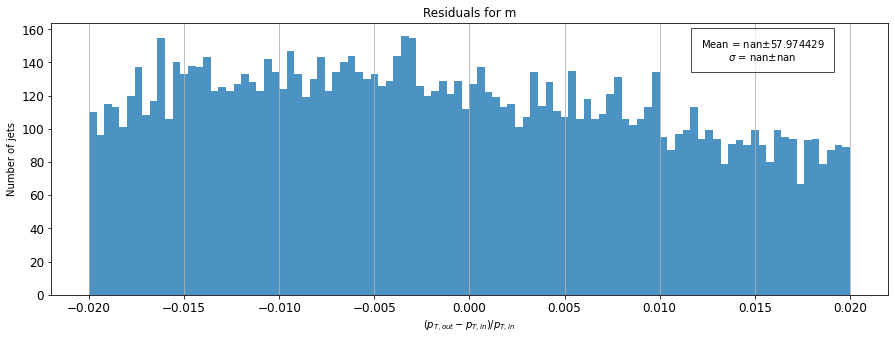

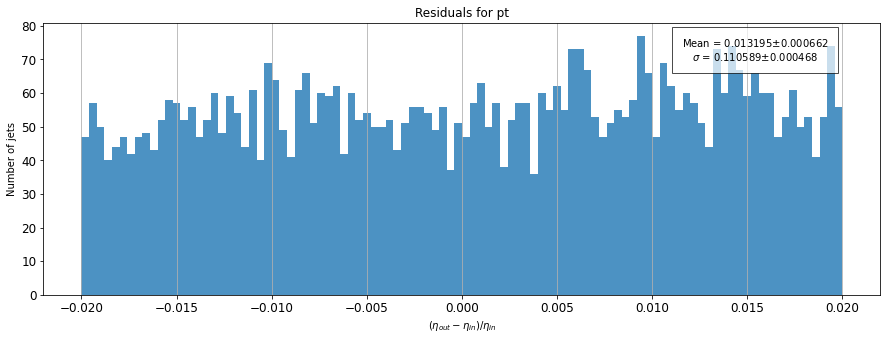

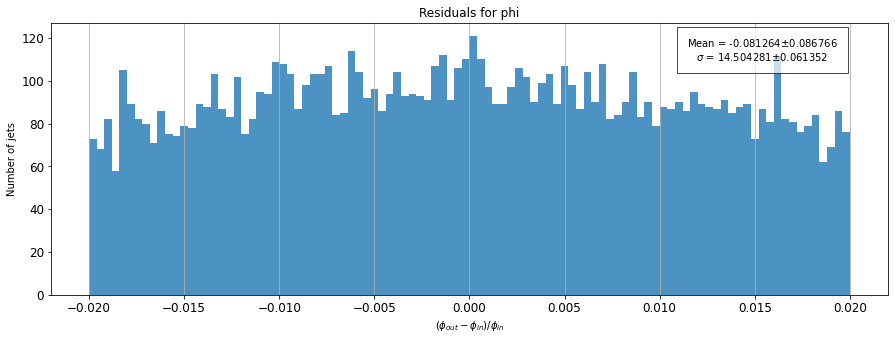

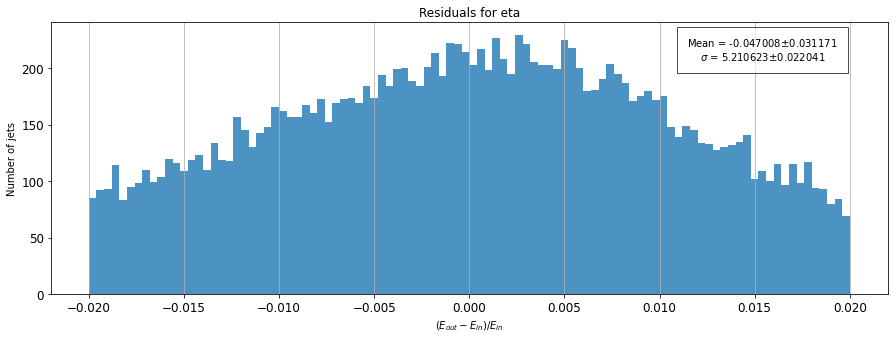

In [180]:
'''PLOTTING RESIDUALS'''

import utils
from scipy import stats

# Labels for x-axes
residual_strings = [
                r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
                r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                r'$(E_{out} - E_{in}) / E_{in}$'
            ]

# Calculate residuals
residuals = (pred - data.detach().numpy()) / data.detach().numpy()
resRange = (-.02, .02)

for idx in np.arange(4):
    plt.figure(figsize=[15,5])
    
    # Plot residual histograms.
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, idx], 
        label='Residuals', 
        linestyle=line_style[0], 
        alpha=alph, 
        bins=100, 
        range=resRange
    )
    
    # Set misc. graph setings
    fig_name = 'Residuals for ' + train.columns[idx]
    plt.title(fig_name)
    plt.xlabel(residual_strings[idx]) 
    plt.ylabel('Number of jets')
    plt.grid(axis='x')

    # Calculate residual statistics for text box
    std = np.std(residuals[:, idx])                       # Get standard-dev
    std_err = utils.std_error(residuals[:, idx])          # Get standard error in standard-dev
    mean = np.nanmean(residuals[:, idx])                  # Get mean
    sem = stats.sem(residuals[:, idx], nan_policy='omit') # Get standard error of mean
    ax = plt.gca()
    
    # Add text box with stats
    plt.text(
        .85, .9, 
        'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), 
        bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
        horizontalalignment='center', 
        verticalalignment='center', 
        transform=ax.transAxes, 
        fontsize=10
    )
    
    # Save Graph
    plt.savefig("graphs/Residuals_" + train_x.columns[idx] + ".png", dpi=200)

    # Show Graph
    plt.show()

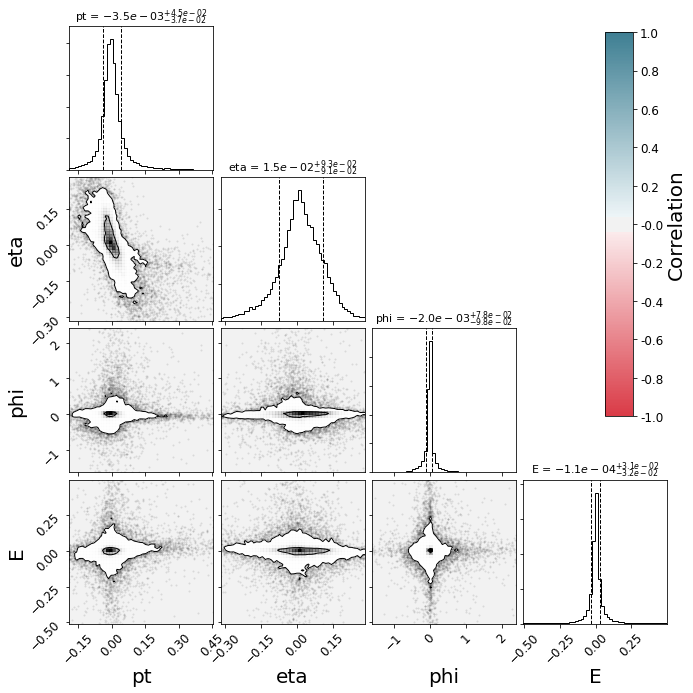

In [185]:
'''PLOTTING CORRELATIONS'''

import corner.corner as corner
import seaborn as sns

# Build residual dataframe
res_df = pd.DataFrame({
    'pt': residuals[:, 0], 
    'eta': residuals[:, 1], 
    'phi': residuals[:, 2], 
    'E': residuals[:, 3]
})

# Build correlation matrix
group_arr = res_df.values
corr = res_df.corr()

# Get values at secific quantiles from each variable.
quantileVal = [.01, .99]         #### Best for our Data : correlations2
# quantileVal = [.005, .995]       #### Intermediate : correlations1
# quantileVal = [.0025, .9975]     #### Original choice : correlations0

qs = np.quantile(group_arr, q=quantileVal, axis=0)
ndim = qs.shape[1]
ranges = [tuple(qs[:, var]) for var in np.arange(ndim)]

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)
norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# Arguments passed later
label_kwargs = {'fontsize': 20}
title_kwargs = {"fontsize": 11}

group = ['pt', 'eta', 'phi', 'E']
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

# Refer : https://corner.readthedocs.io/en/latest/api.html#corner.corner
figure = corner(
    group_arr, 
    range=ranges, 
    plot_density=True, 
    plot_contours=True, 
    no_fill_contours=False, 
    bins=50, 
    labels=group, 
    show_titles=True, 
    label_kwargs=label_kwargs, 
    title_kwargs=title_kwargs, 
    quantiles=(0.16, 0.84),
    levels = (1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.1e'
)

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
# linecol = 'r'
# linstyl = 'dashed'

# Loop over the histograms
for yi in np.arange(ndim):
    for xi in np.arange(yi):
        ax = axes[yi, xi]
        # Set face color according to correlation
        ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi]))

# Add colour-bar
cax = figure.add_axes([.87, .4, .04, 0.55])
cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
cbar.ax.set_ylabel('Correlation', fontsize=20)

# Save the figure
plt.savefig('graphs/correlations2.png', dpi=200)

# Show the figure
plt.show()

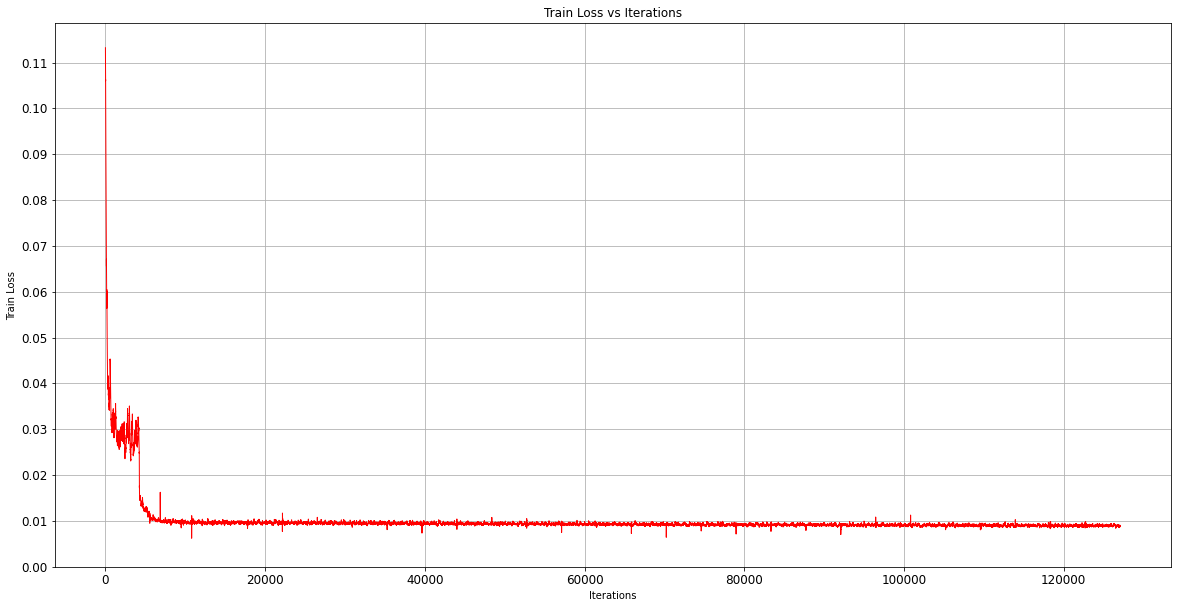

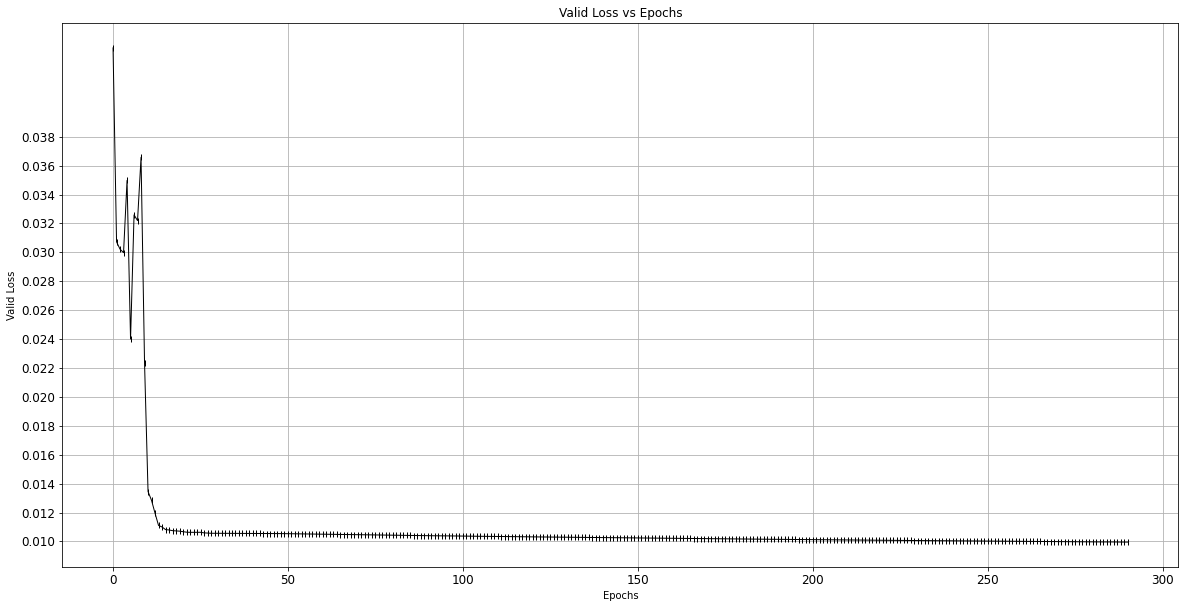

In [212]:
'''TRAIN AND VALID PLOTS'''

# Plot Train plot
plt.figure(figsize=[20,10])
plt.plot(train_loss_list[4500:], 'r')
plt.title("Train Loss vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Train Loss")
plt.yticks(np.arange(0,0.12,0.01))
plt.grid()
plt.savefig('graphs/train_loss.png', dpi=200)
plt.show() 

# Plot Valid Plot
plt.figure(figsize=[20,10])
plt.plot(valid_loss_list[10:], '-|k')
plt.title("Valid Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Valid Loss")
plt.yticks(np.arange(0.010,0.040,0.002))
plt.grid()
plt.savefig('graphs/valid_loss.png', dpi=200)
plt.show()